In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import pickle

# Input plot

In [4]:
with open('tests/timestream/ground_template_filter_array_input.pkl', 'rb') as f:
    ground_template_filter_array_input = pickle.load(f, encoding='latin1')
with open('tests/timestream/ground_template_filter_array_output.pkl', 'rb') as f:
    ground_template_filter_array_output = pickle.load(f, encoding='latin1')

In [5]:
input_array, az, mask, pixel_size, groundmap, lr, filtmask = ground_template_filter_array_input

In [6]:
input_array.shape

(1, 10508)

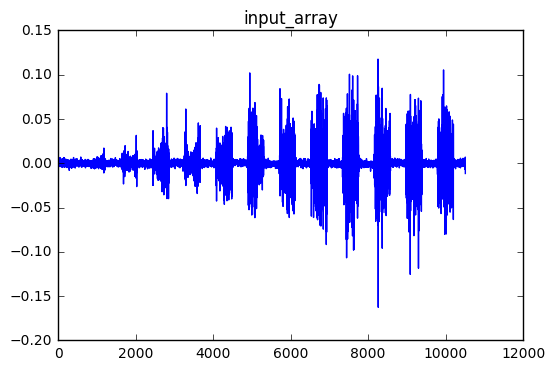

In [7]:
plt.title('input_array')
plt.plot(input_array[0])

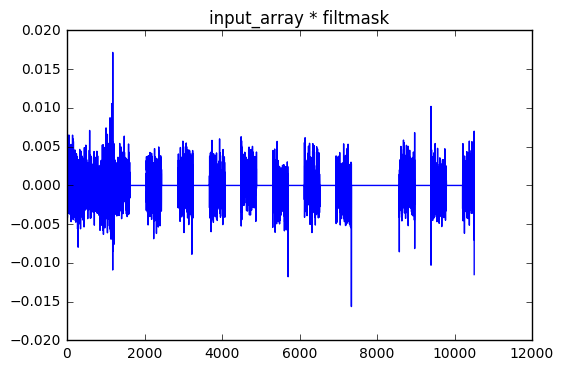

In [8]:
plt.title('input_array * filtmask')
plt.plot(input_array[0] * filtmask[0])

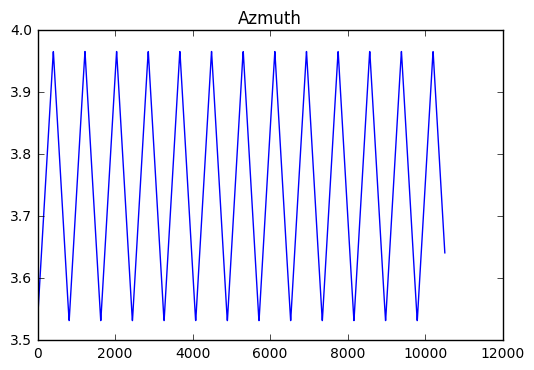

In [9]:
plt.title('Azmuth')
plt.plot(az)

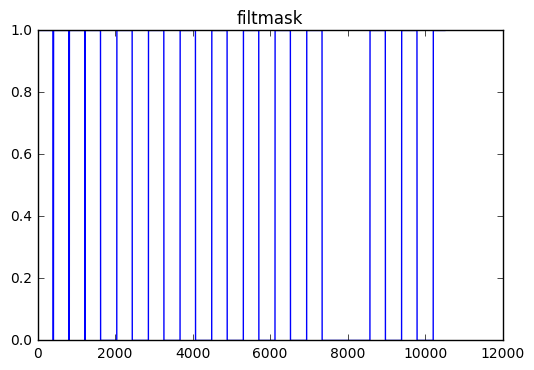

In [10]:
plt.title('filtmask')
plt.plot(filtmask[0])

# Output

# Code

In [11]:
def ground_template_filter_array(
        input_array,
        az,
        mask,
        pixel_size,
        groundmap=False,
        lr=False,
        filtmask=None):
    '''
    Remove ground template from array timestreams

    Parameters
    ----------
    input_array: array_like
        shape: (number of channels, number of time steps)
        Input timestream, mutated inplace.
    az: array_like
        shape: input_array[0]
        The azimuth of the timestream.
    mask: array_like
        shape: input_array
        dtype: bool
    pixel_size: float
    groundmap: bool
        If groundmap = True, then do the exact opposite,
        and remove component from timestream that isn't fixed with the ground
    lr: bool
        If true, ground substraction done separately on left and right moving scans
    filtmask: array_like
        shape: input_array
        dtype: bool
        default: None
        filtmask is preprocessed from mask and addtional masking e.g. from point source
        In largepatch filtmask refers to wafermask_chan_filt
    '''
    # initialize
    if filtmask is not None:
        mask = filtmask
    nCh, nTime = input_array.shape
    az_min = np.min(az)
    az_range = np.max(az) - az_min

    # Calculate number of pixels given the pixel size
    nPix = int(np.round(az_range / pixel_size))
    # an array where each entry is the n-th bin the pixel belongs to
    nPix_per_range = nPix / az_range
    pointing = np.int_((az - az_min) * nPix_per_range)
    pointing[pointing == nPix] = nPix - 1

    # bins are arrays of pixels
    # the signal
    bins_signal = np.zeros((nCh, nPix))
    # number of hits of signals
    bins_hit = np.zeros((nCh, nPix), dtype=np.int32)
    if not lr:
        # calculate ground template
        for i in range(nCh):
            for j in range(nTime):
                k = pointing[j]
                if mask[i, j]:
                    bins_signal[i, k] += input_array[i, j]
                    bins_hit[i, k] += 1
        ok = bins_hit > 0
        bins_signal[ok] /= bins_hit[ok]
        # substraction
        for i in range(nCh):
            for j in range(nTime):
                input_array[i, j] -= bins_signal[i, pointing[j]]

# Tests

In [12]:
import numpy as np
from numpy.testing import assert_allclose

def assertIdenticalList(list1, list2):
    for i, list1i in enumerate(list1):
        if isinstance(list1i, bool):
            assert list1i is list2[i]
        else:
            assert_allclose(list1i, list2[i], rtol=1e-03)

In [13]:
import pickle
import sys
py2 = sys.version_info[0] == 2


def test_ground_template_filter_array():
    with open('tests/timestream/ground_template_filter_array_input.pkl', 'rb') as f:
        if not py2:
            ground_template_filter_array_input = pickle.load(
                f, encoding='latin1')
        else:
            ground_template_filter_array_input = pickle.load(f)
    with open('tests/timestream/ground_template_filter_array_output.pkl', 'rb') as f:
        if not py2:
            ground_template_filter_array_output = pickle.load(
                f, encoding='latin1')
        else:
            ground_template_filter_array_output = pickle.load(f)
    ground_template_filter_array(*ground_template_filter_array_input)
    assertIdenticalList(
        ground_template_filter_array_input,
        ground_template_filter_array_output)

    # debug
    return ground_template_filter_array_input, ground_template_filter_array_output

# Playground

In [14]:
%%timeit
output_array = input_array.copy()
ground_template_filter_array(output_array, az, mask, pixel_size)

10 loops, best of 3: 17.3 ms per loop


In [15]:
output_array = input_array.copy()

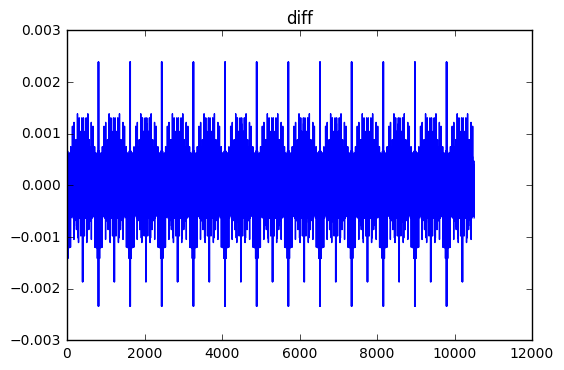

In [16]:
plt.title('diff')
plt.plot(output_array[0] - ground_template_filter_array_output[0][0])

In [17]:
test_ground_template_filter_array()

((array([[ 0.        ,  0.0032052 ,  0.00404837, ..., -0.0070533 ,
           0.00699448, -0.01087422]]),
  array([ 3.53594566,  3.53711146,  3.53820095, ...,  3.64341665,
          3.64234824,  3.64129303]),
  array([[ True,  True,  True, ...,  True,  True,  True]], dtype=bool),
  0.0013962634015954637,
  False,
  False,
  array([[ True,  True,  True, ...,  True,  True,  True]], dtype=bool)),
 (array([[ 0.        ,  0.0032052 ,  0.00404837, ..., -0.0070533 ,
           0.00699448, -0.01087422]]),
  array([ 3.53594566,  3.53711146,  3.53820095, ...,  3.64341665,
          3.64234824,  3.64129303]),
  array([[ True,  True,  True, ...,  True,  True,  True]], dtype=bool),
  0.0013956848012076121,
  False,
  False,
  array([[ True,  True,  True, ...,  True,  True,  True]], dtype=bool)))

[3.54, 3.545, -0.2, 0.15]

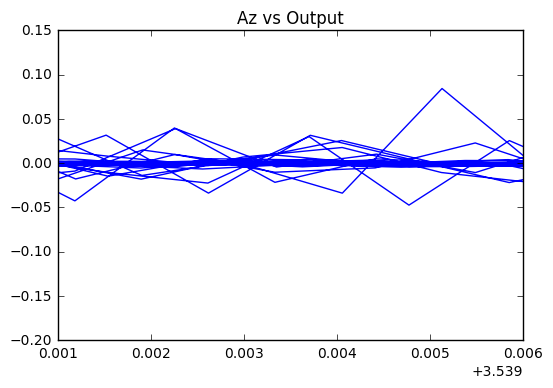

In [29]:
plt.title("Az vs Output")
plt.plot (az, output_array[0])
plt.axis([3.54, 3.545, -.2, .15])